# Tema 7

Sa se creeze si antreneze o retea de tip convolutional pentru unul din seturile de date [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html), [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), [Food101](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html). Intrarea este RGB, de forma 32 x 32 x 3 (la CIFAR10, 100) si dimensiune (max 512) x (max 512) x 3 pentru Food101. 

Cerinte:
1. Efectuati minim 50 de epoci de instruire. 
1. Reprezentati grafic evolutia functiei de cost si a acuratetei, masurate pe setul de antrenare si de validare, folosind tensorboard. **Fisierele tfevents vor fi incluse in arhiva zip care se preda pe elearning**. 
1. Acuratetea unui model neantrenat este de in medie 1/(numarul de clase), adica modelul decide aleator o clasa pentru fiecare input. Modelul vostru va trebui sa ajunga mult peste acest prag de baza. 
1. Cautare de learning rate (LR) cat mai bun: odata gasit arhitectura care performeaza peste pragul de baza, incercati 3 valori diferite pentru hiperparametrul learning rate. Modelul va fi antrenat pe un prcent de 90% de imagini alese aleator din setul de antrenare si validat pe restul de 10% imagini din setul de antrenare. Acel LR care produce cea mai buna acuratete pe setul de validare va fi folosit pentru antrenarea peste toate imaginile din setul initial de antrenare si in final testat pe setul de testare. Setul de testare nu se va folosi in etapa de antrenare sau de validare (cautare de LR optimal).
2. Se va face scalarea datelor din setul de antrenare si de validare, calculand media si deviatia standard pe setul de antrenare; vor rezulta 2 tensori cu cate 3 dimensiuni (cate o valoare pentru canalele R, G, B); se poate folosi functia `compute_mean_std` din prezentarea de laborator. 

Tema va fi predata pana in **22 mai 2024 ora 23** pe elearning. Notarea ei se va face doar in prezenta studentului.

## Import de pachete

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from typing import Tuple

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.2+cu121  Device: cuda


In [12]:
%pip install torchinfo
from torchinfo import summary

%pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Pregatire dataset, dataloader

Codul de mai jos e un punct de plecare posibil / exemplu pentru setul CIFAR100. Utilizarea acestui cod nu e mandatorie. 

In [13]:
batch_size = 64

train_dataset = datasets.CIFAR10('./data',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

assert len(train_dataset) == 50000

test_dataset = datasets.CIFAR10('./data',
                                    train=False,
                                    transform=transforms.ToTensor())

assert len(test_dataset) == 10000



100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):"

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


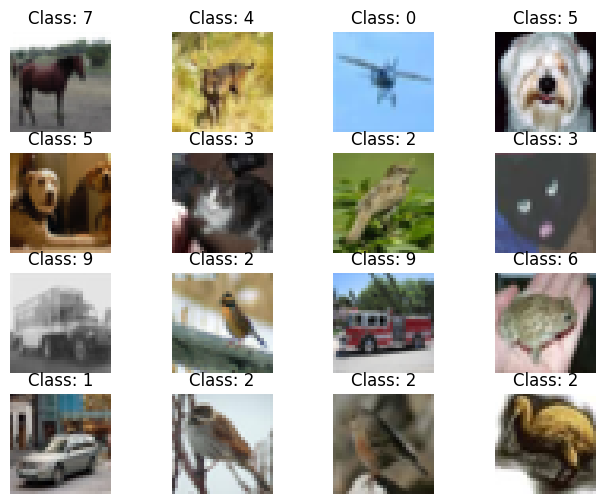

In [17]:
pltsize=1
plt.figure(figsize=(8, 6))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(3,32,32).transpose(1,2,0))
    plt.title('Class: '+str(y_train[i].item()))

## Functii: antrenare, validare, desenare

Definiti in mod convenabil functii de antrenare si de validare. Puteti reutiliza cod din notebook-urile anterioare. 

In [18]:
def train(model: nn.Module, epoch: int, writer: SummaryWriter, log_interval=200):
      # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            writer.add_scalar('Loss/train', loss.data.item(), epoch * len(train_loader) + batch_idx)

In [19]:
def test(model: nn.Module, summary: SummaryWriter, epoch: int) -> None:
    model.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))
    summary.add_scalar("Loss/validation", val_loss, epoch)
    summary.add_scalar("Accuracy/validation", accuracy, epoch)

## Definire model

In [20]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # se declara arhitectura retelei
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.pool7 = nn.MaxPool2d(kernel_size=3, stride=3)

        self.conv8 = nn.Conv2d(512, 1024, kernel_size=3, stride=1)

        self.fc9 = nn.Linear(1024, 100)
        self.fc10 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = torch.relu(x)
        x = self.pool7(x)

        x = self.conv8(x)
        x = torch.relu(x)

        x = x.view(-1, 1024)

        x = self.fc9(x)
        x = torch.relu(x)

        x = self.fc10(x)

        # nu se aplica functie de activare softmax; aceasta e calculata
        # direct in functia de loss, sub forma de log(softmax)
        return x


my_net = MyNet()

In [21]:
summary(my_net, (3, 32, 32)); # 3 canale, 32x32 pixeli

## Antrenare si validare

Se vor tipari si prezenta ploturi (loss, acuratete) pe seturile de antrenare si validare la finalul fiecarei epoci.

In [22]:
# se trece reteaua pe GPU, daca exista
my_net.to(device)
optimizer = torch.optim.SGD(my_net.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-3)

writer = SummaryWriter('runs/CNN_CIFAR10')

# functia de eroare care se optimizeaza de catre optimizator
criterion = nn.CrossEntropyLoss()

In [24]:
%%time
epochs = 50

for epoch in range(1, epochs + 1):
    train(my_net, epoch, writer, 100)
    test(my_net, writer, epoch)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301442
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.300761
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.305909
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.303736
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.305205
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.300581
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.302710
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.300206

Validation set: Average loss: 2.3022, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.304082
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.301372
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.301237
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.302610
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.301190
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303925
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.301786
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.302311

Validation set: Average loss: 2.3017, Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.301655
Train Epoch: 3 [6400/50000 (13%)]